# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import zipfile
import random
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from shutil import copyfile

# Unzipping Training Images

In [ ]:
local_zip = '../input/dogs-vs-cats/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/source')
zip_ref.close()
print('No. of Training Images: ', len(os.listdir('/tmp/source/train')))

No. of Training Images:  25000


In [ ]:
os.listdir('/tmp/source/train')[:10]

['dog.890.jpg',
 'dog.1178.jpg',
 'dog.7845.jpg',
 'dog.4632.jpg',
 'cat.3660.jpg',
 'dog.814.jpg',
 'dog.2066.jpg',
 'dog.8575.jpg',
 'dog.1444.jpg',
 'cat.9803.jpg']

# Visualizing Random Images

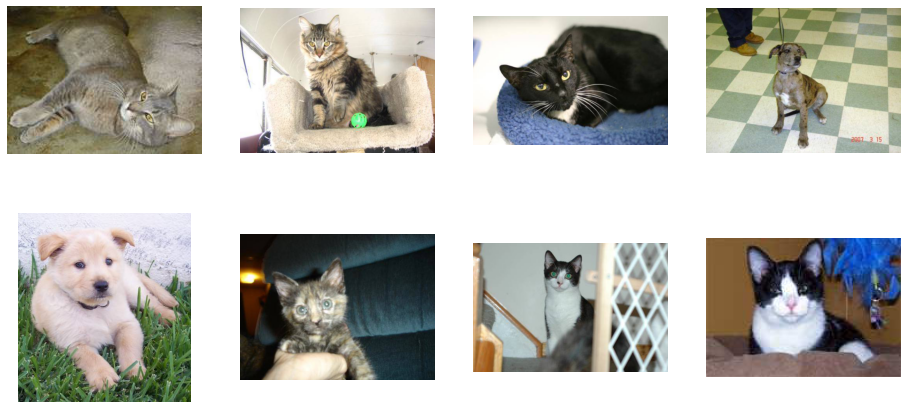

In [ ]:
plt.figure(figsize=(16,16))

images = os.listdir('/tmp/source/train')
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join('/tmp/source/train', img)) 
    fig.imshow(img) 

# Unzipping Testing Images

In [ ]:
local_zip = '../input/dogs-vs-cats/test1.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/source')
zip_ref.close()
print('No. of Testing Images: ',len(os.listdir('/tmp/source/test1')))

No. of Testing Images:  12500


In [ ]:
os.listdir('/tmp/source/test1')[:10]

['10435.jpg',
 '6790.jpg',
 '4644.jpg',
 '1835.jpg',
 '1102.jpg',
 '8962.jpg',
 '6040.jpg',
 '4423.jpg',
 '12072.jpg',
 '1806.jpg']

# Directories

 * cats-v-dogs:
    * training:
        * cats
        * dogs
    * validation:
        * cats
        * dogs

In [ ]:
try:
    parent_dir = '/tmp/cats-v-dogs'
    os.mkdir(parent_dir)

    for dir in ['training', 'validation']:
        path = os.path.join(parent_dir , dir)
        os.mkdir(path)
        for dir in ['cats', 'dogs']:
            n_path = os.path.join(path , dir)
            os.mkdir(n_path)
except OSError:
    print('error')

error


In [ ]:
src_dir = '/tmp/source/train'

cats_train_dir = '/tmp/cats-v-dogs/training/cats/'
cats_valid_dir = '/tmp/cats-v-dogs/validation/cats/'

dogs_train_dir = '/tmp/cats-v-dogs/training/dogs/'
dogs_valid_dir = '/tmp/cats-v-dogs/validation/dogs/'

# List of cats names in all training images
cats =[img for img in os.listdir(src_dir) if img[:3] == 'cat']

# List of dogs names in all training images
dogs =[img for img in os.listdir(src_dir) if img[:3] == 'dog']

# Take 10% of training images for validation    
cats_valid_sample = random.sample(cats, int(0.1*len(cats))) 
dogs_valid_sample = random.sample(dogs, int(0.1*len(dogs)))

for img in os.listdir(src_dir):
    src_img = os.path.join(src_dir, img)
    
    if img[:3] == 'cat':
        if img in cats_valid_sample:
            dest_img = os.path.join(cats_valid_dir, img)
        else:
            dest_img = os.path.join(cats_train_dir, img)
        
    elif img[:3] == 'dog':
        if img in dogs_valid_sample:
            dest_img = os.path.join(dogs_valid_dir, img)
        else:
            dest_img = os.path.join(dogs_train_dir, img)

    copyfile(src_img, dest_img)  

In [ ]:
print('No. of ALL cats : ', len(cats))
print('No. of cats for training: ', len(os.listdir(cats_train_dir)))
print('No. of cats for validation: ', len(os.listdir(cats_valid_dir)))

print('\nNo. of ALL dogs : ', len(dogs))
print('No. of dogs for training: ', len(os.listdir(dogs_train_dir)))
print('No. of dogs for validation: ', len(os.listdir(dogs_valid_dir)))

No. of ALL cats :  12500
No. of cats for training:  12483
No. of cats for validation:  3390

No. of ALL dogs :  12500
No. of dogs for training:  12487
No. of dogs for validation:  3411


# Visualizing Random images of cats for training

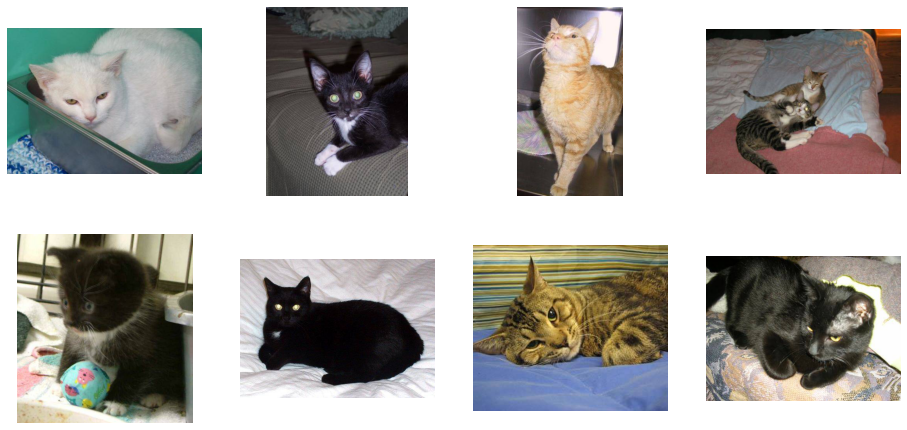

In [ ]:
plt.figure(figsize=(16,16))

images = os.listdir(cats_train_dir)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(cats_train_dir, img)) 
    fig.imshow(img) 

# Visualizing Random images of dogs for validation

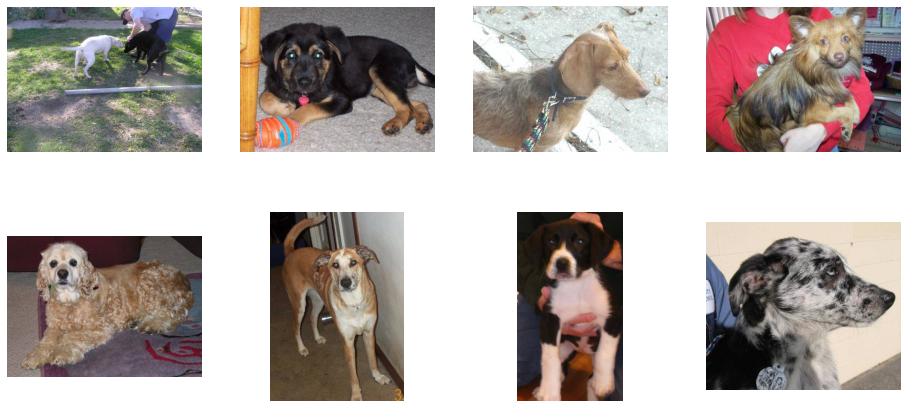

In [ ]:
plt.figure(figsize=(16,16))

images = os.listdir(dogs_valid_dir)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(dogs_valid_dir, img)) 
    fig.imshow(img) 

# Images Augmentation

In [ ]:
# All images will be rescaled by 1./255
# All images will be resized to 150x150

train_datagen = ImageDataGenerator(rescale=1/255,rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2,zoom_range=0.2,horizontal_flip=True, fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1/255)


train_dir = '/tmp/cats-v-dogs/training/'
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=28, class_mode='binary')

valid_dir = '/tmp/cats-v-dogs/validation/'
valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=(150, 150), batch_size=28,class_mode='binary')

Found 24970 images belonging to 2 classes.
Found 6801 images belonging to 2 classes.


# Our CNN

In [ ]:
early_stopping = EarlyStopping( min_delta=0.001, # minimium amount of change to count as an improvement
                                patience=10, # how many epochs to wait before stopping
                                restore_best_weights=True,
                              )

model = Sequential([     Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                         MaxPooling2D(2, 2),

                         Conv2D(32, (3,3), activation='relu'),
                         MaxPooling2D(2,2),
                      
                         Conv2D(64, (3,3), activation='relu'),
                         MaxPooling2D(2,2),

                         Conv2D(64, (3,3), activation='relu'),
                         MaxPooling2D(2,2),
                      

                         Flatten(),

                         Dense(512, activation='relu'),

                         Dense(1, activation='sigmoid')
                  ])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 64)       

In [ ]:
history = model.fit(train_generator, epochs=20, verbose=1,validation_data=valid_generator, callbacks = [early_stopping])

Epoch 1/20
892/892 [==============================] - 186s 207ms/step - loss: 0.6926 - accuracy: 0.5283 - val_loss: 0.6511 - val_accuracy: 0.6274
Epoch 2/20
892/892 [==============================] - 185s 207ms/step - loss: 0.6595 - accuracy: 0.5993 - val_loss: 0.5731 - val_accuracy: 0.6967
Epoch 3/20
892/892 [==============================] - 184s 206ms/step - loss: 0.5992 - accuracy: 0.6802 - val_loss: 0.4836 - val_accuracy: 0.7758
Epoch 4/20
892/892 [==============================] - 184s 207ms/step - loss: 0.5401 - accuracy: 0.7280 - val_loss: 0.5261 - val_accuracy: 0.7339
Epoch 5/20
892/892 [==============================] - 183s 205ms/step - loss: 0.5100 - accuracy: 0.7484 - val_loss: 0.4391 - val_accuracy: 0.7922
Epoch 6/20
892/892 [==============================] - 184s 206ms/step - loss: 0.4991 - accuracy: 0.7559 - val_loss: 0.4378 - val_accuracy: 0.8002
Epoch 7/20
892/892 [==============================] - 184s 206ms/step - loss: 0.4669 - accuracy: 0.7788 - val_loss: 0.3788 -

<AxesSubplot:>

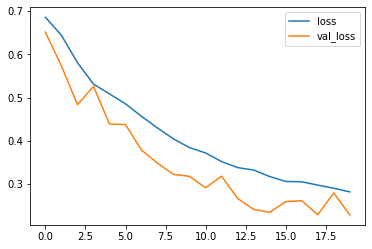

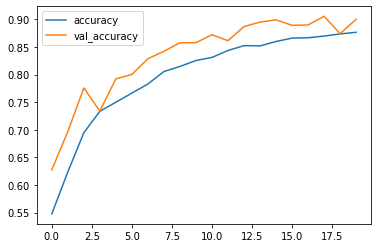

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [ ]:
model.evaluate(valid_generator)

243/243 [==============================] - 17s 70ms/step - loss: 0.2292 - accuracy: 0.9002


[0.22915008664131165, 0.9001617431640625]

# Predicting of Testing Images


In [ ]:
def convert_imgs_to_tensors(img_folder):
  # dimensions of images
  img_width, img_height = 150, 150

  # load all images into a list
  images = []

  for img in os.listdir(img_folder):
    img = os.path.join(img_folder, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.
    images.append(img)

  # stack up images list to pass for model
  images = np.vstack(images)

  return images

In [ ]:
test_dir = '/tmp/source/test1'
test_images= convert_imgs_to_tensors(test_dir)

In [ ]:
pred = np.argmax(model.predict(test_images),axis =1)
pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
test_dir = '/tmp/source/test1'
test_data = os.listdir(test_dir)
test_df = pd.DataFrame({ "id" : test_data})
test_df

,id
0,10435.jpg
1,6790.jpg
2,4644.jpg
3,1835.jpg
4,1102.jpg
...,...
12495,4113.jpg
12496,1652.jpg
12497,3826.jpg
12498,8679.jpg


In [ ]:
"""test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_dataframe(test_df, test_dir, target_size = (150, 150), x_col = "id", y_col = None,
                                                    batch_size = 10, class_mode = None, shuffle = True, color_mode="rgb")"""

'test_datagen = ImageDataGenerator(rescale = 1./255)\ntest_generator = test_datagen.flow_from_dataframe(test_df, test_dir, target_size = (150, 150), x_col = "id", y_col = None,\n                                                    batch_size = 10, class_mode = None, shuffle = True, color_mode="rgb")'

In [ ]:
test_df['id'] = test_df['id'].str.split('.').str[0]
test_df['label'] = pred
test_df.head(20)

,id,label
0,10435,0
1,6790,0
2,4644,0
3,1835,0
4,1102,0
5,8962,0
6,6040,0
7,4423,0
8,12072,0
9,1806,0


In [ ]:
test_df[test_df['label'] == 1]

,id,label


In [ ]:
test_df.to_csv('submission.csv',index=False)